In [1]:
# %matplotlib inline
from numpy.random import RandomState
import numpy
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import string
from sklearn.decomposition import TruncatedSVD

In [19]:
import os
path_to_model = 'C:/Users/prana/Desktop/BE Project/LegalBuddyServer/OPPClassifiers/SecondaryClassifiers/Models/InternationalandSpecificAudiences/AudienceType.sav'
# os.listdir(path_to_model)

# Create Multilabel Dataset

In [3]:
#preprocess
df = pd.read_csv('dataset.csv')
df = df.dropna()

classes = list(df.Category.unique())
total_unique_clauses = df.Clause.unique().size

#creating dict for appending
classes_dict = {}
for single_class in classes:
    classes_dict[single_class] = list(numpy.zeros(total_unique_clauses))

#creating the df
data = {}
for index,row in df.iterrows():
    try : 
        data[row['Clause']].append(row['Category'])
        data[row['Clause']] = list(set(data[row['Clause']]))  
    except:
        data[row['Clause']] = [row['Category']]

        Clause = []
Category = []
for key in data.keys():
    Clause.append(key)
    Category.append(data[key])
    
data = pd.DataFrame({
    'Clause' : Clause,
    'Category' : Category
})
index = 0
for category_list in data.Category:
    for category in category_list:
        classes_dict[category][index] = 1
    index += 1

classes_dict = pd.DataFrame(classes_dict)

In [4]:
data.head()

,Clause,Category
0,"If you live in Canada, please read our Canadia...",[Citizens from other countries]
1,Your California Privacy Rights. If you live in...,[Californians]
2,If you live in California and have an establis...,[Californians]
3,"To exercise your rights, you can email us or w...",[Californians]
4,These sites and apps are not intended for chil...,[Children]


In [5]:
classes_dict.head()

,Citizens from other countries,Californians,Children,Other,Europeans
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0


In [6]:
one_hot_encoded_data = pd.concat([data, classes_dict], axis=1)
one_hot_encoded_data.drop(columns=['Category']).to_csv('multilabel_dataset.csv')

In [7]:
df = pd.read_csv('multilabel_dataset.csv')
df = df.dropna()
train = df.sample(frac=0.8, random_state = RandomState())
test = df.loc[~df.index.isin(train.index)]
validation = train.sample(frac=0.2, random_state=200)

In [8]:
df.columns.values[2:]

array(['Citizens from other countries', 'Californians', 'Children',
       'Other', 'Europeans'], dtype=object)

# Visualizing Data

In [9]:
counts = []
categories = list(df.columns.values[2:])
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,Citizens from other countries,91.0
1,Californians,129.0
2,Children,301.0
3,Other,30.0
4,Europeans,42.0


Text(0.5, 0, 'category')

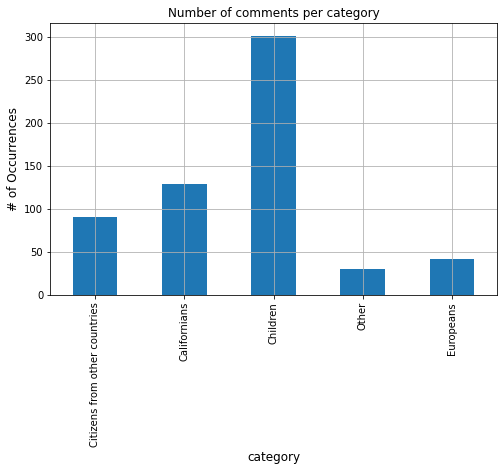

In [10]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

# Preprocessing Data

In [11]:
# cleaned_clause = []
# for clause in df.Clause:
#     clause = clause.lower()
#     clause = re.sub(r'[0-9]+', '',clause) #number removal
#     clause = clause.translate(string.maketrans(“”,””), string.punctuation) #removinf punctuations
#     clause = clause.strip() #whitespace removal
#     clause
#     break

In [12]:
x_test = test.Clause
x_train = train.Clause

In [13]:
y = train.iloc[:,2:]
y_test = test.iloc[:,2:]

categories = list(y.columns)

In [14]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(df.Clause)

<584x1907 sparse matrix of type '<class 'numpy.float64'>'
	with 22987 stored elements in Compressed Sparse Row format>

# Naive Bayes

In [15]:
prediction_pd = {}
classifier_list_nb = []
for category in categories:
    clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_nb.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Citizens from other countries
Test accuracy is 0.9145299145299145
... Processing Californians
Test accuracy is 0.9572649572649573
... Processing Children
Test accuracy is 0.9743589743589743
... Processing Other
Test accuracy is 0.9743589743589743
... Processing Europeans
Test accuracy is 0.9658119658119658


array([[[104,   0],
        [ 10,   3]],

       [[ 87,   1],
        [  4,  25]],

       [[ 49,   1],
        [  2,  65]],

       [[114,   0],
        [  3,   0]],

       [[111,   0],
        [  4,   2]]], dtype=int64)

# Linear SVC

In [16]:
prediction_pd = {}
classifier_list_svc = []
clf = OneVsRestClassifier(LinearSVC(), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_svc.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Citizens from other countries
Test accuracy is 0.9658119658119658
... Processing Californians
Test accuracy is 0.9829059829059829
... Processing Children
Test accuracy is 0.9572649572649573
... Processing Other
Test accuracy is 0.9658119658119658
... Processing Europeans
Test accuracy is 0.9743589743589743


array([[[103,   1],
        [  3,  10]],

       [[ 87,   1],
        [  1,  28]],

       [[ 49,   1],
        [  4,  63]],

       [[113,   1],
        [  3,   0]],

       [[111,   0],
        [  3,   3]]], dtype=int64)

# Logistic Regression

In [17]:
prediction_pd = {}
classifier_list_lr = []
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
for category in categories:
    print('... Processing {}'.format(category))
    clf.fit(tfidf.transform(x_train), y[category])
    prediction = clf.predict(tfidf.transform(x_test))
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    prediction_pd[category] = prediction
    classifier_list_lr.append(clf)
prediction_pd = pd.DataFrame(prediction_pd)
multilabel_confusion_matrix(y_test, prediction_pd)

... Processing Citizens from other countries
Test accuracy is 0.9230769230769231
... Processing Californians
Test accuracy is 0.9572649572649573
... Processing Children
Test accuracy is 0.9572649572649573
... Processing Other
Test accuracy is 0.9743589743589743
... Processing Europeans
Test accuracy is 0.9658119658119658


array([[[104,   0],
        [  9,   4]],

       [[ 88,   0],
        [  5,  24]],

       [[ 50,   0],
        [  5,  62]],

       [[114,   0],
        [  3,   0]],

       [[111,   0],
        [  4,   2]]], dtype=int64)

In [20]:
import pickle
#saving model
list_of_classifiers = classifier_list_nb
pickle.dump((tfidf, list_of_classifiers), open(path_to_model, 'wb'))

In [17]:
with open(path_to_model, 'rb') as model:
    vect, clfs = pickle.load(model)

In [16]:
clfs

[OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=None, max_iter=100,
                                                  multi_class='auto',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=None,
                                                  solver='sag', tol=0.0001,
                                                  verbose=0, warm_start=False),
                     n_jobs=1),
 OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                  dual=False, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=